In [1]:
import pandas as pd 
from datetime import datetime, timedelta
import ipaddress



In [2]:
logs_df = pd.read_csv("../dataset/processed_logs/combined/malicious.csv")
attacks_df = pd.read_csv("../dataset/ground_truth/all_attacks.csv")

In [3]:
len(logs_df)

752164

In [4]:
logs_df.head()

,ts,src_ip,dst_ip
0,2024-09-04 00:00:21.241051904-06:00,192.168.57.10,192.168.255.255
1,2024-09-04 00:00:29.579170816-06:00,192.168.57.9,224.0.0.251
2,2024-09-04 00:00:29.581031168-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb
3,2024-09-04 00:00:29.581422080-06:00,192.168.57.9,224.0.0.251
4,2024-09-04 00:00:29.581625088-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb


In [5]:
logs_df.tail()

,ts,src_ip,dst_ip
752159,2024-09-07 17:59:33.521572096-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb
752160,2024-09-07 17:59:33.787298048-06:00,192.168.57.9,224.0.0.251
752161,2024-09-07 17:59:33.787736832-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb
752162,2024-09-07 17:59:33.788310016-06:00,192.168.57.9,224.0.0.251
752163,2024-09-07 17:59:33.788398080-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb


In [6]:
logs_df['ts'] = pd.to_datetime(logs_df['ts'], errors='coerce')
attacks_df['Timestamp'] = pd.to_datetime(attacks_df['Timestamp'], errors='coerce')



In [7]:
logs_df.src_ip.unique()

array(['192.168.57.10', '192.168.57.9', 'fe80::33b2:2f9:4983:bf8e',
       '192.168.57.5', 'fe80::74ba:e5ff:fe79:a4cd', '192.168.57.6',
       'fe80::28b4:7dff:fef1:3798', '192.168.0.1', '192.168.57.4',
       'fe80::875:6bff:fe2d:24d1', 'fe80::11ed:eed3:ca89:f286',
       '192.168.57.8', 'fe80::acea:32ff:fef8:de1f', '172.28.1.7',
       '172.28.0.1', 'fe80::5167:8e31:df7d:f379',
       'fe80::30c8:94ff:fe23:6289', 'fe80::3548:4c67:f93b:299c',
       'fe80::5022:ea85:5e74:6fbe', 'fe80::7ee9:ba4c:e2e4:4cff',
       'fe80::d479:90ff:fea7:e9a5', '0.0.0.0', '255.255.255.255', '::',
       '192.168.57.13', 'fe80::1ff2:8a31:40a:38a', 'fe80::7798:2',
       'fe80::7798:6', 'fe80::7798:3', 'fe80::7798:1', 'fe80::7798:4',
       'fe80::7798:5'], dtype=object)

In [8]:
logs_df.dst_ip.unique()

array(['192.168.255.255', '224.0.0.251', 'ff02::fb', ...,
       '169.254.91.211', '169.254.129.6', '169.254.179.27'], dtype=object)

In [9]:
logs_df['label'] = 0


In [10]:
logs_df.head()

,ts,src_ip,dst_ip,label
0,2024-09-04 00:00:21.241051904-06:00,192.168.57.10,192.168.255.255,0
1,2024-09-04 00:00:29.579170816-06:00,192.168.57.9,224.0.0.251,0
2,2024-09-04 00:00:29.581031168-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0
3,2024-09-04 00:00:29.581422080-06:00,192.168.57.9,224.0.0.251,0
4,2024-09-04 00:00:29.581625088-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0


In [11]:
attacks_df.Target.unique()

array(['192.168.57.0/24', '192.168.57.8', '192.168.57.2', '192.168.57.13',
       '192.168.57.6', '192.168.57.4', '192.168.57.5', '192.168.57.10',
       '192.168.57.11', '192.168.0.0/16', '192.168.57.12',
       '172.26.15.122'], dtype=object)

In [12]:
time_window_before = timedelta(minutes=1)
time_window_after = timedelta(minutes=2)



In [13]:

# Function to check if an IP matches or falls within the target (handling subnets as well)
def is_ip_in_target(ip, target):
    try:
        # Convert the IP to an ipaddress object
        ip = ipaddress.ip_address(ip)
        # Handle exact IP matches or CIDR notations
        if '/' in target:  # CIDR notation (subnet)
            network = ipaddress.ip_network(target, strict=False)
            return ip in network
        else:  # Single IP
            return ip == ipaddress.ip_address(target)
    except ValueError:
        return False  # Return False if IP format is incorrect

# Re-label logs based on both timestamp proximity and target IP/subnet
logs_df['label'] = 0  # Reset labels





In [14]:
# Iterate through each attack entry
for _, attack_row in attacks_df.iterrows():
    attack_time = attack_row['Timestamp']
    target_ip = attack_row['Target']
    attack_ip = "192.168.57.13"
        
    
    # Define time range around the attack
    start_time = attack_time -  time_window_before
    end_time = attack_time + time_window_after
    
    # Label logs that match both time range and either src_ip or dst_ip matches the target
    logs_df.loc[
        (logs_df['ts'] >= start_time) & 
        (logs_df['ts'] <= end_time) &
        (
            logs_df['dst_ip'].apply(lambda x: is_ip_in_target(x, target_ip)) |
            logs_df['src_ip'].apply(lambda x: is_ip_in_target(x, attack_ip))
        ), 
        'label'] = 1

In [15]:
logs_df.label.sum()

65822

In [16]:
logs_df.head()

,ts,src_ip,dst_ip,label
0,2024-09-04 00:00:21.241051904-06:00,192.168.57.10,192.168.255.255,0
1,2024-09-04 00:00:29.579170816-06:00,192.168.57.9,224.0.0.251,0
2,2024-09-04 00:00:29.581031168-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0
3,2024-09-04 00:00:29.581422080-06:00,192.168.57.9,224.0.0.251,0
4,2024-09-04 00:00:29.581625088-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0


In [17]:
logs_df.to_csv("../dataset/processed_logs/combined/malicious.csv",index=False)

/tmp/ipykernel_3172243/2710950197.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = logs_df.resample('15T', on='ts').sum()


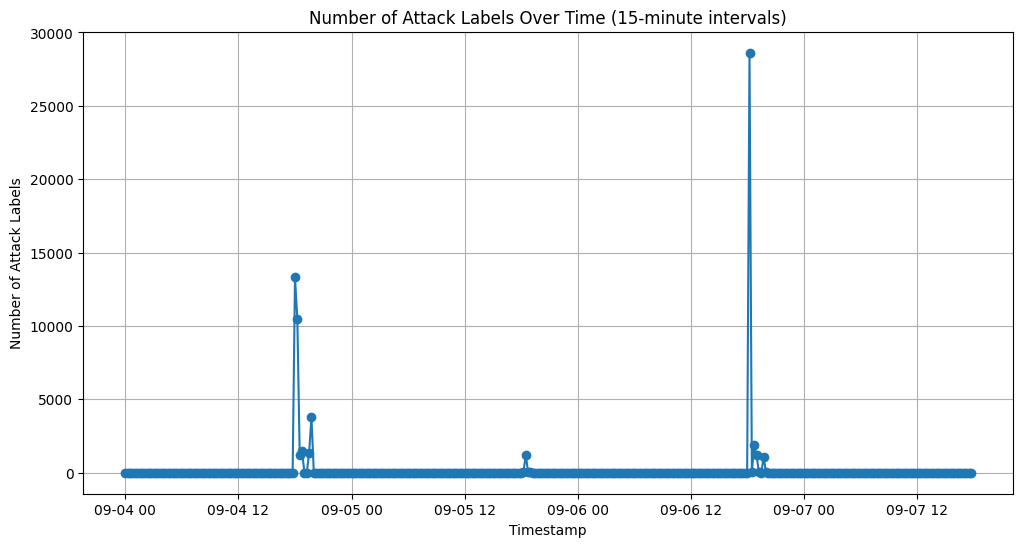

In [18]:
import matplotlib.pyplot as plt

# Resample the logs_df to 15-minute intervals and sum the attack labels
resampled_df = logs_df.resample('15T', on='ts').sum()

# Plot the resampled data
plt.figure(figsize=(12, 6))
plt.plot(resampled_df.index, resampled_df['label'], marker='o')
plt.title('Number of Attack Labels Over Time (15-minute intervals)')
plt.xlabel('Timestamp')
plt.ylabel('Number of Attack Labels')
plt.grid(True)
plt.show()

### Getting final CSVs

In [19]:
import os

final_dir = "../dataset/processed_logs/cyberdome"
os.makedirs(final_dir,exist_ok=True)

In [20]:
benign_df = pd.read_csv("../dataset/processed_logs/combined/benign.csv")

In [21]:
benign_df["label"] = 0

In [22]:
benign_df.head()

,ts,src_ip,dst_ip,label
0,2024-09-01 00:00:21.112210944-06:00,192.168.57.9,224.0.0.251,0
1,2024-09-01 00:00:21.114290944-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0
2,2024-09-01 00:00:21.114968064-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0
3,2024-09-01 00:00:21.114968064-06:00,192.168.57.9,224.0.0.251,0
4,2024-09-01 00:00:21.377451008-06:00,192.168.57.9,224.0.0.251,0


In [23]:
benign_df.tail()

,ts,src_ip,dst_ip,label
38859,2024-09-03 23:58:51.216803072-06:00,192.168.57.4,192.168.255.255,0
38860,2024-09-03 23:59:31.021046016-06:00,192.168.57.9,224.0.0.251,0
38861,2024-09-03 23:59:31.021765120-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0
38862,2024-09-03 23:59:32.031281920-06:00,192.168.57.9,224.0.0.251,0
38863,2024-09-03 23:59:32.031625984-06:00,fe80::33b2:2f9:4983:bf8e,ff02::fb,0


In [24]:
benign_df.rename(columns={'ts': 'timestamp', 'src_ip': 'src_computer', 'dst_ip': 'dst_computer'}, inplace=True)

In [25]:
logs_df.rename(columns={'ts': 'timestamp', 'src_ip': 'src_computer', 'dst_ip': 'dst_computer'}, inplace=True)

#### Assign ip numerical value for later usage

In [26]:
ip_mapping = {}

# Function to map IPs to numerical values
def map_ip(ip):
    if ip not in ip_mapping:
        ip_mapping[ip] = len(ip_mapping)
    return ip_mapping[ip]

benign_df['src_computer'] = benign_df['src_computer'].apply(map_ip)
benign_df['dst_computer'] = benign_df['dst_computer'].apply(map_ip)
logs_df['src_computer'] = logs_df['src_computer'].apply(map_ip)
logs_df['dst_computer'] = logs_df['dst_computer'].apply(map_ip)

print(ip_mapping)

{'192.168.57.9': 0, 'fe80::33b2:2f9:4983:bf8e': 1, '192.168.57.10': 2, '172.28.1.7': 3, '192.168.57.4': 4, 'fe80::74ba:e5ff:fe79:a4cd': 5, 'fe80::11ed:eed3:ca89:f286': 6, '192.168.57.8': 7, '192.168.0.1': 8, 'fe80::875:6bff:fe2d:24d1': 9, 'fe80::d479:90ff:fea7:e9a5': 10, 'fe80::5022:ea85:5e74:6fbe': 11, '172.28.0.1': 12, 'fe80::7ee9:ba4c:e2e4:4cff': 13, 'fe80::30c8:94ff:fe23:6289': 14, 'fe80::acea:32ff:fef8:de1f': 15, '::': 16, 'fe80::5167:8e31:df7d:f379': 17, '0.0.0.0': 18, '192.168.57.5': 19, 'fe80::3548:4c67:f93b:299c': 20, '192.168.57.6': 21, '192.168.57.12': 22, 'fe80::28b4:7dff:fef1:3798': 23, '172.26.0.1': 24, '192.168.57.11': 25, '192.168.57.2': 26, 'fe80::4040:43ff:fe09:2fdc': 27, 'fe80::b01e:d7ff:fe01:9e36': 28, '224.0.0.251': 29, 'ff02::fb': 30, '192.168.255.255': 31, '185.125.190.57': 32, 'ff02::2': 33, 'ff02::16': 34, 'ff02::1:3': 35, '224.0.0.252': 36, '239.255.255.250': 37, '185.125.190.56': 38, 'ff02::1:2': 39, 'ff02::1:ff7d:f379': 40, 'ff02::1': 41, '255.255.255.255': 

In [27]:
import json

json_file_path = os.path.join(final_dir, 'node_map.json')

with open(json_file_path, 'w') as json_file:
    json.dump(ip_mapping, json_file)

print(f"IP mapping saved to {json_file_path}")

IP mapping saved to ../dataset/processed_logs/cyberdome/node_map.json


#### Find snapshot

In [28]:
initial_timestamp = pd.to_datetime(benign_df['timestamp']).min()

def calculate_snapshot(timestamp, initial_timestamp):
    # Creating 1 minute snapshot
    return int((timestamp - initial_timestamp).total_seconds() // 60)

benign_df['snapshot'] = pd.to_datetime(benign_df['timestamp']).apply(lambda x: calculate_snapshot(x, initial_timestamp))
logs_df['snapshot'] = pd.to_datetime(logs_df['timestamp']).apply(lambda x: calculate_snapshot(x, initial_timestamp))

print(benign_df.head())
print(logs_df.head())

                             timestamp  src_computer  dst_computer  label  \
0  2024-09-01 00:00:21.112210944-06:00             0            29      0   
1  2024-09-01 00:00:21.114290944-06:00             1            30      0   
2  2024-09-01 00:00:21.114968064-06:00             1            30      0   
3  2024-09-01 00:00:21.114968064-06:00             0            29      0   
4  2024-09-01 00:00:21.377451008-06:00             0            29      0   

   snapshot  
0         0  
1         0  
2         0  
3         0  
4         0  
                            timestamp  src_computer  dst_computer  label  \
0 2024-09-04 00:00:21.241051904-06:00             2            31      0   
1 2024-09-04 00:00:29.579170816-06:00             0            29      0   
2 2024-09-04 00:00:29.581031168-06:00             1            30      0   
3 2024-09-04 00:00:29.581422080-06:00             0            29      0   
4 2024-09-04 00:00:29.581625088-06:00             1            30      0 

In [29]:
benign_df.tail()

,timestamp,src_computer,dst_computer,label,snapshot
38859,2024-09-03 23:58:51.216803072-06:00,4,31,0,4318
38860,2024-09-03 23:59:31.021046016-06:00,0,29,0,4319
38861,2024-09-03 23:59:31.021765120-06:00,1,30,0,4319
38862,2024-09-03 23:59:32.031281920-06:00,0,29,0,4319
38863,2024-09-03 23:59:32.031625984-06:00,1,30,0,4319


In [30]:
logs_df.head()

,timestamp,src_computer,dst_computer,label,snapshot
0,2024-09-04 00:00:21.241051904-06:00,2,31,0,4320
1,2024-09-04 00:00:29.579170816-06:00,0,29,0,4320
2,2024-09-04 00:00:29.581031168-06:00,1,30,0,4320
3,2024-09-04 00:00:29.581422080-06:00,0,29,0,4320
4,2024-09-04 00:00:29.581625088-06:00,1,30,0,4320


In [31]:
benign_df.to_csv(f"{final_dir}/train.csv",index=False)

In [32]:
logs_df[['timestamp', 'src_computer', 'dst_computer', 'label', 'snapshot']].to_csv(f"{final_dir}/test.csv", index=False)